### Neural Network student performace

- I denne filen kommer jeg til å ta for meg trening og tuning av neural network klasifikasjon for student performace datasettet. Jeg kommer til å bruke tensorflow keras Sequential og Model med og uten et dropoutlayer og sammelige hvilke av disse alternativere som prestere best.

- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [3]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [4]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'), 
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen tuning i større grad vil ha god overførings verdi til nye data for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nyttig for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter, noe som jeg kommer til å benytte meg av pga. eldre hardware.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.

- For å vurdere disse modellene har jeg valgt å bruke disse metricene Accuracy, Precision, Recall, F1-score og Roc_auc. Accuracy er et mål på hvor treffsikre prediksjonene er for hele datasettet. Precision er et mål på hvor godt modellen klarer å predikere positive representasjoner for den enkelte klassen målt opp mot det totale antallet positive prediksjoner. Recall er et mål på hvor godt modellen klarer å predikere positive repsentasjoner for den enkelte klassen målt opp mot det det faktiske antalle av positive representasjoner. F1-score er en samlet representasjon av precision og recall som balansere hverandre slik at du en god verdi på den enne av disse vil balanseres av den dårlig verdi på den andre. Roc_auc er et mål på arealet under en ROC curve som representere forholdet mellom ekte positive prediksjoner og falske positive prediksjoner.

- For precision, recall, f1 og roc_auc er det imidlertid hvert å merke seg at disse metricene i utgangspunktet er laget for å vurdere binære klassifikasjoner og at derfor må disse vurderes enkeltvis og så samles, jeg har valgt å bruke et uvektet macro gjennomsnitt for å oppnå dette.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene.

-	Pga. elde hardware og problemer med lang kjøre tid på flere av modellene når disse tunes med nested cross validation vil jeg derfor hvor det er hensiktsmessig, dele opp tuning i flere deler for å unngå eksponentiell kjøre tid. Dette er selvfølgelig ikke gunstig, da det kan være mulige påvirkende faktorer mellom tuning parametere som du ikke observere når disse tunes sekvensielt, men det dessverre nødvendig for noen av modellene. Der hvor det er mulig vil jeg heller bruke et redusert antall splitter av datasettet i kryss valideringen for å redusere kjøre tiden.

-	Etter at jeg har gjennomført tuningen av modellene kommer jeg til å kjøre en endelig test av modellene med de parameter verdiene jeg har kommet fram til. Dette gjør jeg slik GridSearchCV ikke skal velge de parameter verdiene som passer best for deler av datasettet, slik at jeg får et testresultat for de endelige modellene som er representative for hele datasettet.

-	For de avsluttende testene kommer jeg til å bruke en oppdeling av datasettet på 5 splitter for den ytre loopen og 4 for den indre. Dette gjøre at jeg vil få en god fordeling mellom training og test data og en typisk 80-20 splitt mellom traning og test i den ytre testing av datasettet.

#### Tensorflow Keras 

- Som første modell starter jeg med en Keras Sequential modell som har 3 hidden layers i tillegg til input og utput layer. 

-  For alle modellene komm jeg til å bruke softmax som aktiverings fuksjon for output layeret da det er denne som er bergnet for denne typen datasett. For loss function så bruks sparse categorical crossentropy da det er denne function som er riktig å bruke for klassifikasjons datasett med flere utput klasser og ikke et binært output.

- For tuningen av modellene kommer jeg til å fokusere på følgene verdier, aktiverings funksjon for hidden layers, optimizer ved compilering, antall nevroner for 1 og 2 hidden layer, batch size, learing rate for optimizer og dropout for de modellene som inkludere dropout layer.

- Videre kommer jeg til å tune optimizer, activation function og loss function først og i hovedsak beholde disse resultatene for tuning av resten av modellene da disse i stor grad påvirkes av selve datasettet. Jeg har valg å gjøre dette som et tidssparende tiltak da jeg mener dette fortsatt viser tilstrekkelig forståelse for tuningen av disse parameterne. Men i en reell situasjon vil jeg selvfølgelig tune disse parameterne mer utfyllende for alle modellen. Jeg kommer også til å bruke samme fremgang måte for andre parametere for de modellene hvor jeg kun legger til dropout layer uten å endre modellen noe videre enn det.

- Jeg har gjort en grunnleggen sjekk i forkant sli at tuning verdiene jeg starter ikke er for langt unna jeg som blir slutt resultatet. Jeg valg å gjøre dette da parametere som er veldig ulik slutt resultat vil kunne påvirker resultatet for tuningene av de forskjellige parameterene. 

- Det kunne selfølgelig vært implementert endre mere utfylende tuning og utprøving av antall hidden layers, forskjellige activation functions for de individuelle hidden layers osv. Men jeg har valgt å begrense tuningen min til det utvalget jeg har gjort ut fra tidshensyn og det totale omfanget, da jeg mener at dette tilstrekkelig demonstere god forståelse for tuning prosessen og hvilke mulighet det er og hvilke hensyn som bør tas.  

In [7]:
def create_model(optimizer='adam', activation='swish', hidden_neurons=75, layers=2, dropout=0.1, reduction_factor=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))   
    model.add(Dense(hidden_neurons, activation=activation))    
    for layer in range(0, layers+1):
        hidden_neurons = int(hidden_neurons*reduction_factor)
        if(hidden_neurons >= 3):            
            model.add(Dense(hidden_neurons, activation=activation))
    if(dropout > 0):
        model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
keras_sequential_1 = KerasClassifier(model=create_model, verbose=0)

In [8]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [75],
    'model__layers': [2],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'model__dropout':[0],
}
keras_estimators_1, keras_scores_train_1, keras_scores_test_1, keras_cv_results_1 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_f1'>

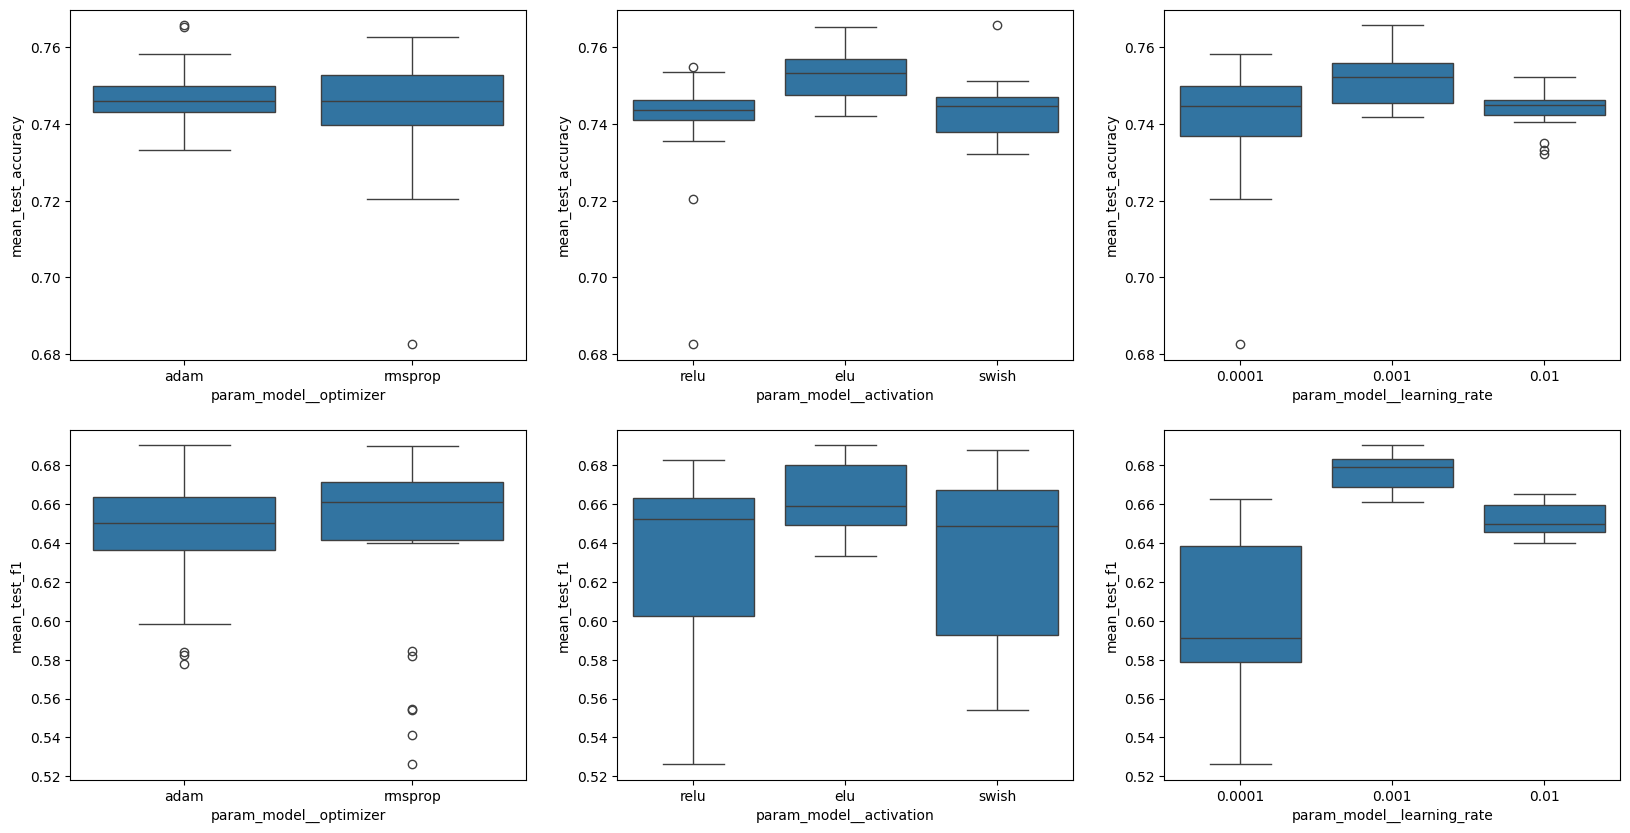

In [9]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
sb.boxplot(data=keras_cv_results_1, x='param_model__optimizer', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_1, x='param_model__activation', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_1, x='param_model__learning_rate', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_1, x='param_model__optimizer', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_1, x='param_model__activation', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_1, x='param_model__learning_rate', y='mean_test_f1', ax=ax[1,2])

In [11]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150], 
    'model__layers': [2, 5, 10], 
    'model__reduction_factor': [0.3, 0.5, 0.7],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

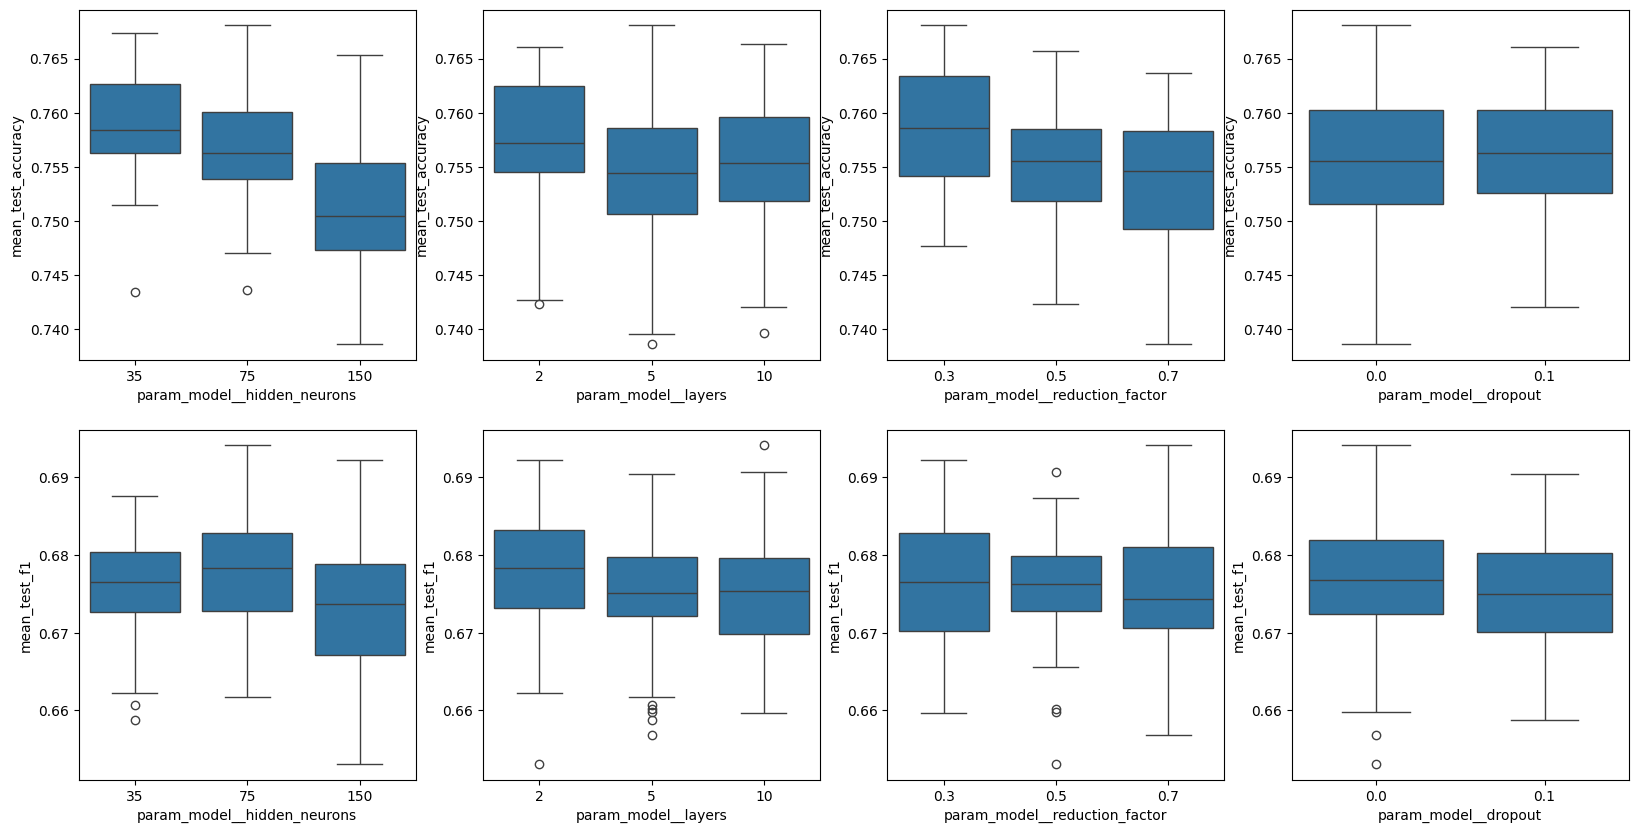

In [12]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=keras_cv_results_2, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_2, x='param_model__reduction_factor', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_2, x='param_model__dropout', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_2, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_2, x='param_model__reduction_factor', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_2, x='param_model__dropout', y='mean_test_f1', ax=ax[1,3])


In [13]:
keras_class_param = {
    'batch_size': [5, 10, 25],
    'epochs': [5, 10 , 20],
    'model__hidden_neurons': [20, 35, 75],
    'model__layers': [2],
    'model__reduction_factor': [0.3],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_epochs', ylabel='mean_test_f1'>

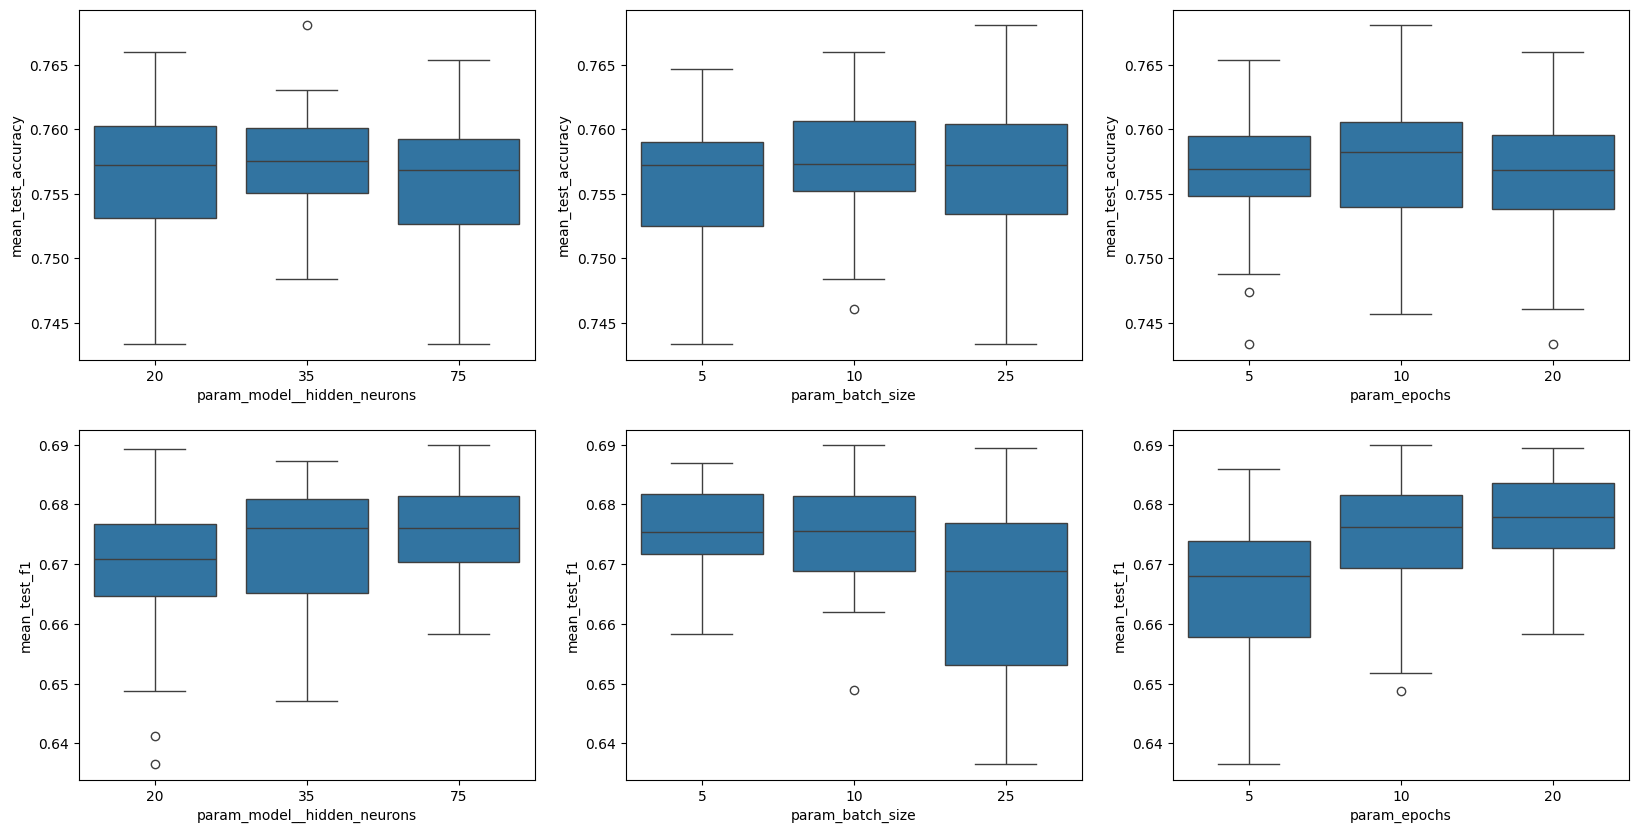

In [15]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
sb.boxplot(data=keras_cv_results_3, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_3, x='param_epochs', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_3, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_3, x='param_epochs', y='mean_test_f1', ax=ax[1,2])

In [26]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [20],
    'model__hidden_neurons': [75],
    'model__layers': [2],
    'model__reduction_factor': [0.3],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [27]:
keras_sequential_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.753165,0.687000,0.668019,0.672699
std,0.012236,0.023335,0.018826,0.021948
min,0.736723,0.666050,0.651961,0.654423
25%,0.749153,0.674336,0.655566,0.658482
50%,0.753394,0.683866,0.663440,0.666252
75%,0.755932,0.684236,0.669793,0.674978
max,0.770621,0.726514,0.699334,0.709358


In [28]:
keras_sequential_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.823406,0.794482,0.754547,0.767979
std,0.003712,0.008123,0.003565,0.002972
min,0.816897,0.783323,0.751826,0.764863
25%,0.823962,0.789503,0.752728,0.765244
50%,0.824809,0.795573,0.753176,0.768129
75%,0.825424,0.801688,0.754282,0.769861
max,0.825940,0.802323,0.760725,0.771797


Keras Model

In [20]:
def create_model_2(optimizer='adam', activation='swish', hidden_neurons=75, layers=2, dropout=0.1, reduction_factor=0.5, learning_rate=0.001):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons, activation=activation))(input)
    if(layers > 0):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(x)     
    if(layers > 1):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(input)
    if(dropout > 0):
        x = (Dropout(dropout))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)   
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
keras_model = KerasClassifier(model=create_model_2, verbose=0)

In [21]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [0, 1, 2],
    'model__reduction_factor': [0.3 ,0.5, 0.7],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_model, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

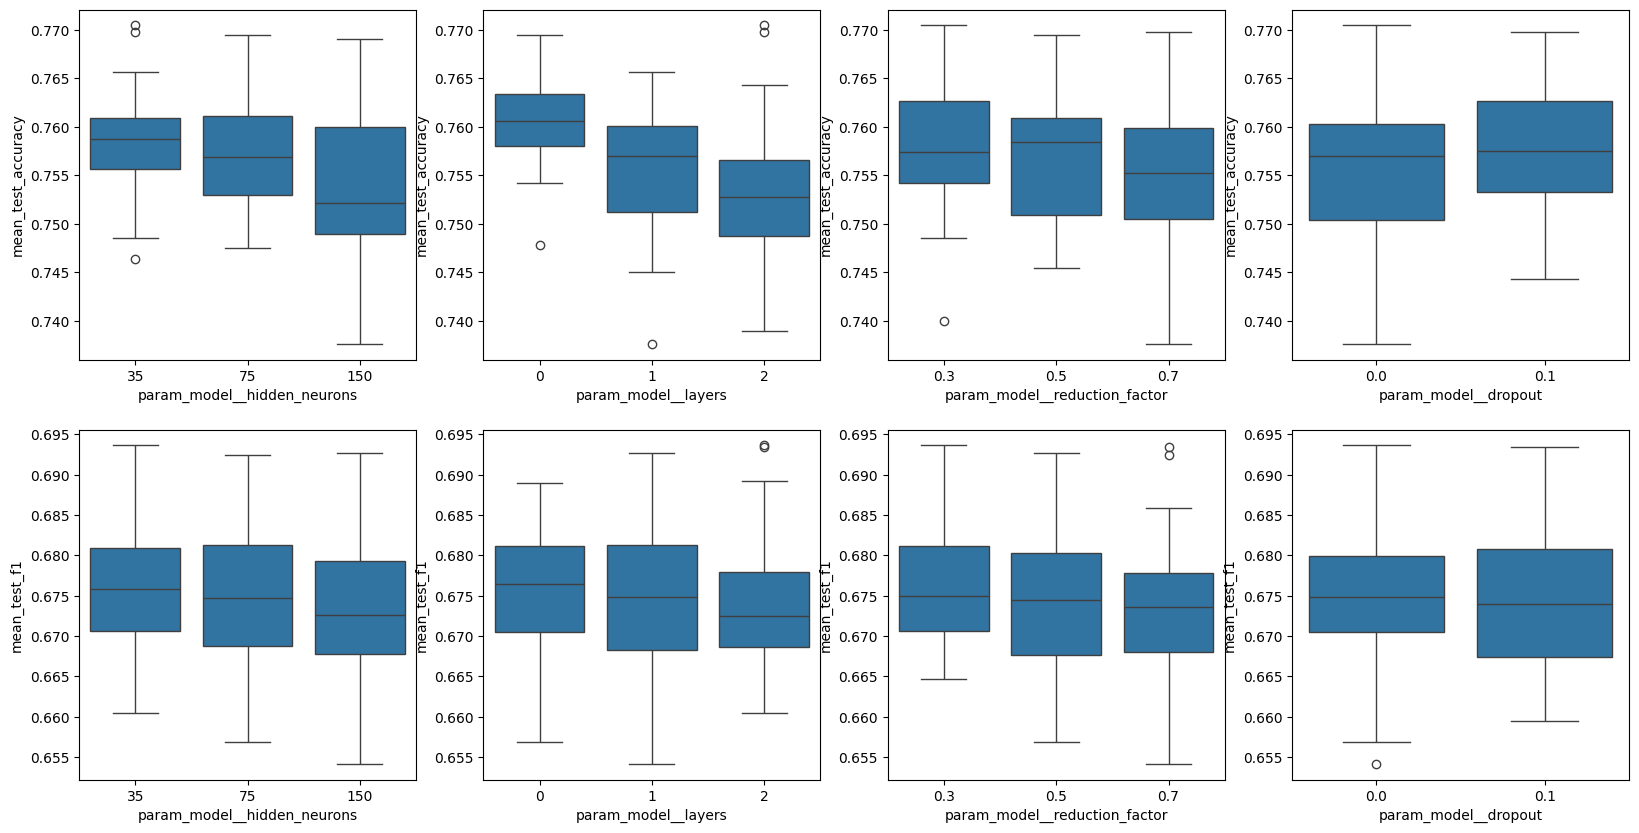

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=keras_cv_results_4, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_4, x='param_model__layers', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_4, x='param_model__reduction_factor', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_4, x='param_model__dropout', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_4, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_4, x='param_model__layers', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_4, x='param_model__reduction_factor', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_4, x='param_model__dropout', y='mean_test_f1', ax=ax[1,3])


In [29]:
keras_class_param = {
    'batch_size': [5, 10, 25],
    'epochs': [5, 10, 20],
    'model__hidden_neurons': [35, 75],
    'model__layers': [0, 1],
    'model__reduction_factor': [0.3 ,0.5],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0.1],
}
keras_estimators_5, keras_scores_train_5, keras_scores_test_5, keras_cv_results_5 = train(features, targets, keras_model, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_epochs', ylabel='mean_test_f1'>

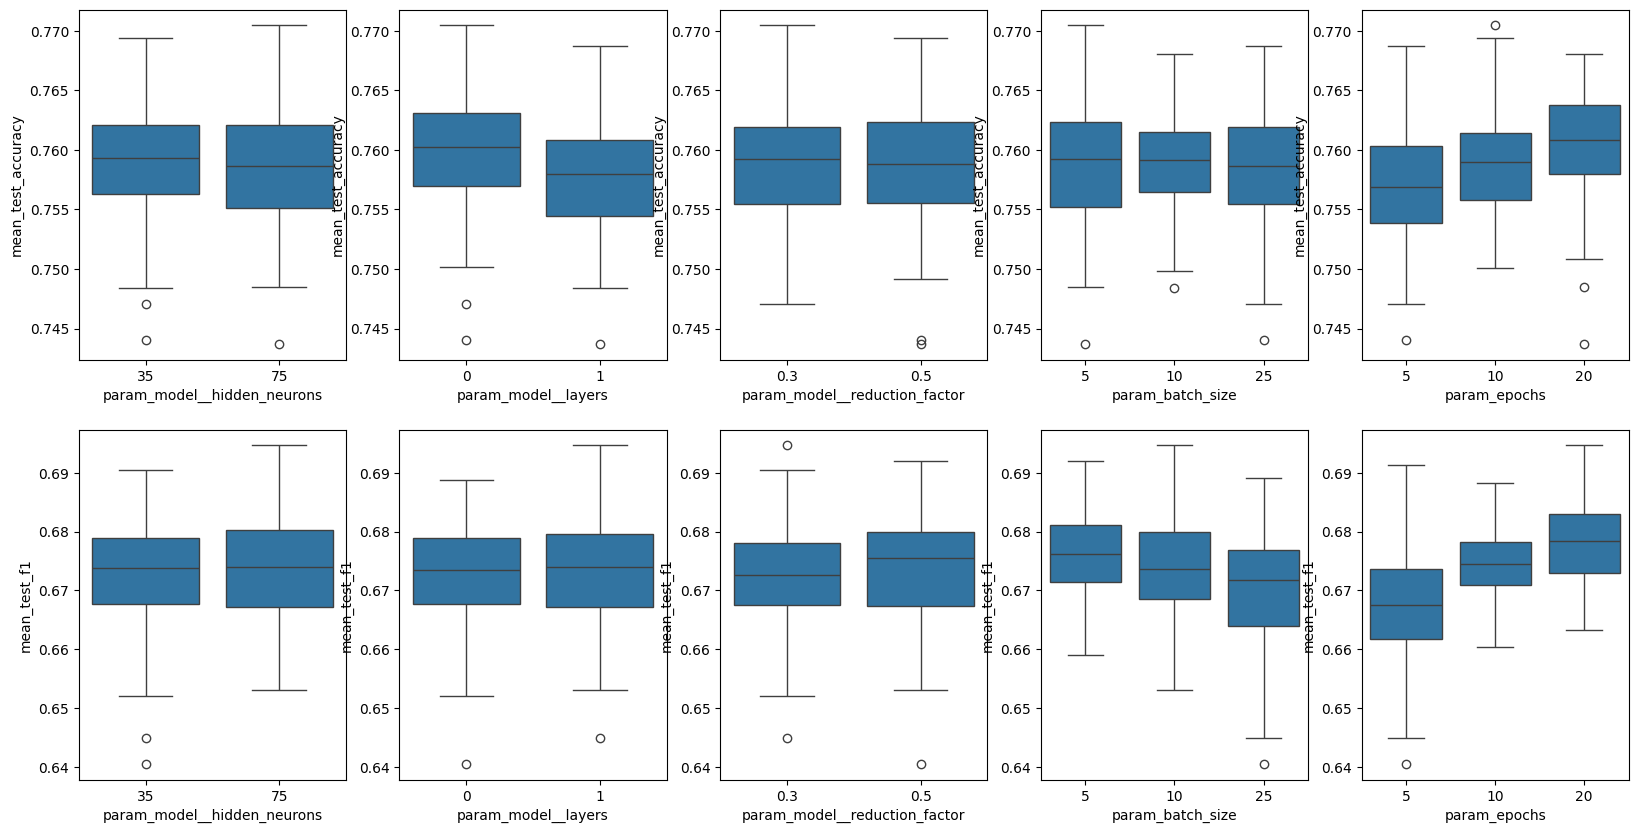

In [31]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
sb.boxplot(data=keras_cv_results_5, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_5, x='param_model__layers', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_5, x='param_model__reduction_factor', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_5, x='param_batch_size', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_5, x='param_epochs', y='mean_test_accuracy', ax=ax[0, 4])
sb.boxplot(data=keras_cv_results_5, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_5, x='param_model__layers', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_5, x='param_model__reduction_factor', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_5, x='param_batch_size', y='mean_test_f1', ax=ax[1,3])
sb.boxplot(data=keras_cv_results_5, x='param_epochs', y='mean_test_f1', ax=ax[1,4])


In [32]:
keras_class_param = {
    'batch_size': [5, 10],
    'epochs': [20, 40],
    'model__hidden_neurons': [35, 75],
    'model__layers': [0, 1],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0.1],
}
keras_estimators_6, keras_scores_train_6, keras_scores_test_6, keras_cv_results_6 = train(features, targets, keras_model, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_epochs', ylabel='mean_test_f1'>

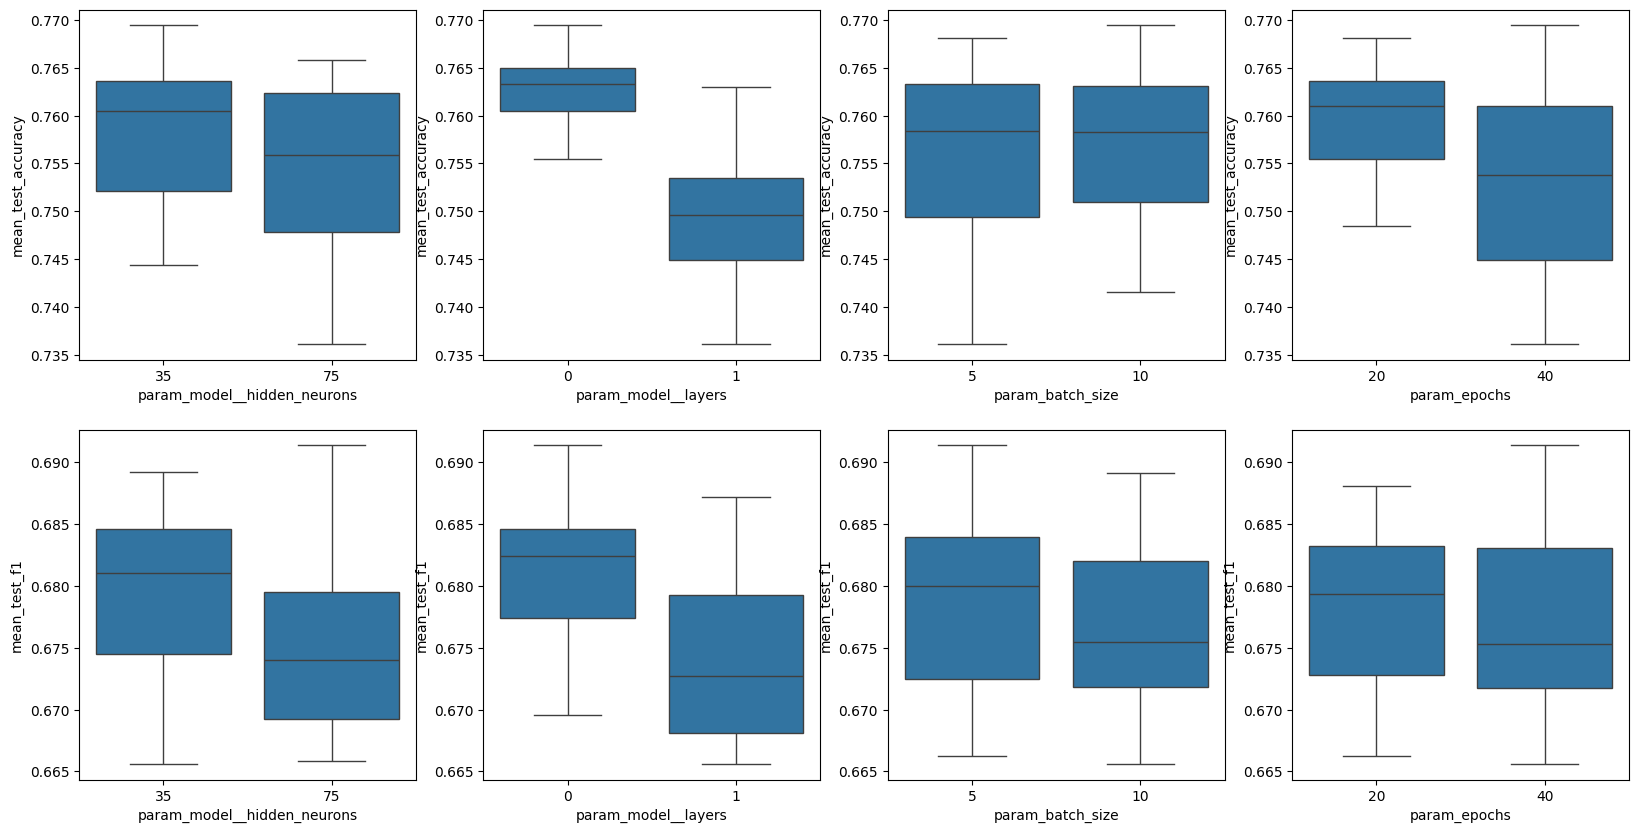

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=keras_cv_results_6, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_6, x='param_model__layers', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_6, x='param_batch_size', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_6, x='param_epochs', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_6, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_6, x='param_model__layers', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_6, x='param_batch_size', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_6, x='param_epochs', y='mean_test_f1', ax=ax[1,3])

In [35]:
keras_class_param = {
    'batch_size': [5],
    'epochs': [20],
    'model__hidden_neurons': [35],
    'model__layers': [0],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0.1],
}
keras_model_estimators_final, keras_model_scores_train_final, keras_model_scores_test_final, keras_model_cv_results_final = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [37]:
keras_model_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767405,0.709751,0.678771,0.686672
std,0.003390,0.007272,0.005742,0.007439
min,0.762712,0.699351,0.672659,0.676270
25%,0.766102,0.706155,0.672999,0.682244
50%,0.767232,0.710867,0.680463,0.688390
75%,0.769231,0.714423,0.682074,0.691702
max,0.771751,0.717958,0.685659,0.694753


In [36]:
keras_model_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.787014,0.739372,0.702686,0.713107
std,0.004466,0.006451,0.003747,0.004527
min,0.780446,0.728787,0.698795,0.706842
25%,0.785250,0.738501,0.699851,0.710780
50%,0.787288,0.741234,0.702036,0.713169
75%,0.790336,0.742733,0.704739,0.716690
max,0.791749,0.745606,0.708009,0.718054


In [38]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final['accuracy'].mean(),keras_sequential_scores_train_final['precision'].mean(), keras_sequential_scores_train_final['recall'].mean(), keras_sequential_scores_train_final['f1'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final['accuracy'].mean(),keras_sequential_scores_test_final['precision'].mean(), keras_sequential_scores_test_final['recall'].mean(), keras_sequential_scores_test_final['f1'].mean()],
    'Keras Model Train': [keras_model_scores_train_final['accuracy'].mean(),keras_model_scores_train_final['precision'].mean(), keras_model_scores_train_final['recall'].mean(), keras_model_scores_train_final['f1'].mean()],
    'Keras Model Test': [keras_model_scores_test_final['accuracy'].mean(),keras_model_scores_test_final['precision'].mean(), keras_model_scores_test_final['recall'].mean(), keras_model_scores_test_final['f1'].mean()],
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Model Train,Keras Model Test
Metric,,,,
Accuracy:,0.823406,0.753165,0.787014,0.767405
Precision:,0.794482,0.687000,0.739372,0.709751
Recall:,0.754547,0.668019,0.702686,0.678771
F1:,0.767979,0.672699,0.713107,0.686672
